In [1]:
# Importar funciones de procesamiento de datos
from limpieza_datos import read_item_index_to_entity_id_file, convert_rating, convert_kg, visualize_kg_from_file, generate_entity_to_type_mapping, dataset_split, DataLoader, TrainSet, summarize_dataset

# Importar la clase del modelo y funciones de entrenamiento/evaluación
from custom_mkr import MultiKR
from train_and_evaluate import train_epoch, evaluate_model, train_and_evaluate

# Importar funciones para modelar el EDA
from edas import setup_model_and_dataloaders, multiKR_cost_function, decode_solution, define_initial_frequency, define_variables_for_multiKR,define_possible_values_for_multiKR, multiKR_cost_wrapper

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Procesar los datos y capturar los mapeos
item_index_old2new, entity_id2index = read_item_index_to_entity_id_file()

In [3]:
convert_rating(item_index_old2new)
entity_id2index, relation_id2index = convert_kg()

In [4]:
# Mapeo de tipos de relaciones a tipos de entidades ajustado a tu descripción
relation_to_entity_types = {
    'book.book.genre': ('book', 'genre'),
    'book.written_work.date_of_first_publication': ('book', 'date'),
    'book.literary_series.author': ('series', 'author'),
    'comic_books.series.publisher': ('comic_series', 'publisher'),
    'book.written_work.author': ('book', 'author'),
    'book.literary_series.works_in_this_series': ('series', 'work'),
    'book.written_work.translation': ('original_work', 'translation'),
    'book.written_work.subject': ('work', 'subject'),
    'book.written_work.literary_series': ('work', 'series'),
    'book.written_work.previous_in_series': ('work', 'previous_work'),
}


# Generar el mapeo de ID de entidad a tipo basado en el archivo kg.txt y el mapeo relation_to_entity_types
entity_to_type = generate_entity_to_type_mapping('./MKR-data/kg.txt', relation_to_entity_types)

# Mapeo de índice de relación a nombre de relación (debes definir este mapeo basado en tu datos)
index_to_relation_name = {
    0: 'book.book.genre',
    1: 'book.written_work.date_of_first_publication',
    2: 'book.literary_series.author',
    3: 'comic_books.series.publisher',
    4: 'book.written_work.author',
    5: 'book.literary_series.works_in_this_series',
    6: 'book.written_work.translation',
    7: 'book.written_work.subject',
    8: 'book.written_work.literary_series',
    9: 'book.written_work.previous_in_series'
}

In [5]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [6]:
visualize_kg_from_file(
    file_path='./MKR-data/kg_final.txt',
    entity_id2index=entity_id2index,
    index_to_relation_name=index_to_relation_name,
    relation_to_entity_types=relation_to_entity_types,
    num_triples_to_plot=100 ,
    min_relations_per_node=1
)

In [7]:
# Preparar los datos para el entrenamiento y la evaluación
ratings = np.loadtxt('./MKR-data/ratings_final.txt', dtype=np.int32)
train_data, eval_data, test_data = dataset_split(ratings)

# Convertir los conjuntos de datos a DataLoader
train_loader = DataLoader(TrainSet(train_data), batch_size=64, shuffle=True)
val_loader = DataLoader(TrainSet(eval_data), batch_size=64, shuffle=True)
eval_loader = DataLoader(TrainSet(test_data), batch_size=64, shuffle=False)


In [8]:
print("Training dataset summary:")
summarize_dataset(TrainSet(train_data))

print("\nEvaluation dataset summary:")
summarize_dataset(TrainSet(eval_data))

# Comprobar una muestra de los datos cargados
sample_user, sample_item, sample_target = next(iter(eval_loader))
print("\nSample batch from eval_loader:")
print(f"User tensor: {sample_user}")
print(f"Item tensor: {sample_item}")
print(f"Target tensor: {sample_target}")


Training dataset summary:
Total examples: 34392, Positive examples: 14443.0, Negative examples: 19949.0
Positive proportion: 0.42

Evaluation dataset summary:
Total examples: 11464, Positive examples: 4856.0, Negative examples: 6608.0
Positive proportion: 0.42

Sample batch from eval_loader:
User tensor: tensor([ 8327,  1225,  9461,  8064,  6224,  3574,  8157,   268,  5008,  8872,
         3144,  5964,  6084,  1242,  9617,  9239,  8788,  1454,   477,  7409,
         7712,   351,  9166,  3600,  6388,  3443,  9122,  3875,  7501,  8924,
         6068,  9823,  4825,  2931,  7819,  3994,  7999,   425,  6741,  5695,
          905,  4595,  9601,     0,  5701,  6954,  3050,  3554, 10678,  8750,
         3225,  4894, 10474,  1766,   800,  1539,   322,  5071, 10556,  2243,
         8940,   901,  3882,  9614])
Item tensor: tensor([ 3155,  3894,  9158,  3257,  1787,    81, 14265,   750, 12386,  1804,
         1345, 11477,  5123,   356,    43,  4041,   533,   240,     5,  7451,
         1446,   578

In [9]:
# Inicializar el modelo MultiKR
user_num = len(np.unique(ratings[:, 0]))  # Número de usuarios únicos
item_num = len(_)  # Número de ítems únicos
entity_num = len(entity_id2index)  # Número de entidades únicas
relation_num = len(relation_id2index)  # Número de relaciones únicas
model = MultiKR(user_num, item_num, entity_num, relation_num, n_layer=2, embed_dim=64, hidden_layers=[128, 64], dropouts=[0.5, 0.5], output_rec=1)

In [18]:
model

MultiKR(
  (user_embed): Embedding(10765, 64)
  (item_embed): Embedding(0, 64)
  (entity_embed): Embedding(24127, 64)
  (relation_embed): Embedding(10, 64)
  (compress_weights): ParameterDict(
      (ee): Parameter containing: [torch.FloatTensor of size 64x1]
      (ev): Parameter containing: [torch.FloatTensor of size 64x1]
      (ve): Parameter containing: [torch.FloatTensor of size 64x1]
      (vv): Parameter containing: [torch.FloatTensor of size 64x1]
  )
  (compress_biases): ParameterDict(
      (e): Parameter containing: [torch.FloatTensor of size 1]
      (v): Parameter containing: [torch.FloatTensor of size 1]
  )
  (kg_layers): Sequential(
    (layer_0): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.5, inplace=False)
    )
    (layer_1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.5, inpl

In [10]:
import torch
# Definir el optimizador y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss()

In [11]:
# # Número de épocas para entrenar
epochs = 5

# # Listas para almacenar resultados de entrenamiento y validación
# train_losses = []
# val_losses = []
# val_aucs = []

# # Entrenamiento y evaluación
# for epoch in range(epochs):
#     train_loss, val_loss, val_auc = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_function, epoch, 'rec')
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     val_aucs.append(val_auc)

# # Graficar pérdidas y AUC
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# axs[0].plot(range(1, epochs+1), train_losses, label='Training Loss')
# axs[0].plot(range(1, epochs+1), val_losses, label='Validation Loss')
# axs[0].set_title("Loss Over Epochs")
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Loss')
# axs[0].legend()

# axs[1].plot(range(1, epochs+1), val_aucs, label='Validation AUC')
# axs[1].set_title("Validation AUC Over Epochs")
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('AUC')
# axs[1].legend()

# plt.tight_layout()
# plt.show()



In [12]:
# evaluate_model(model, eval_loader, epoch)

In [13]:
# Define tus variables y valores posibles
variables = define_variables_for_multiKR()
possible_values = define_possible_values_for_multiKR()

# Define la frecuencia inicial para los valores posibles de cada variable
frequency = define_initial_frequency(variables, possible_values)

# Convierte `possible_values` a una estructura compatible con CategoricalSampling si es necesario
possible_values_numeric = {i: possible_values[var] for i, var in enumerate(variables)}
frequency_numeric = {i: [1/len(possible_values[var])] * len(possible_values[var]) for i, var in enumerate(variables)}


In [14]:
possible_values_numeric

{0: [32, 64, 128],
 1: [0.01, 0.001, 0.0001],
 2: [64, 128, 256],
 3: ['64',
  '128',
  '256',
  '64_64',
  '128_128',
  '256_256',
  '64_128',
  '128_256',
  '128_64',
  '256_128',
  '64_128_256',
  '256_128_64',
  '64_64_64',
  '128_128_128',
  '256_256_256'],
 4: [0.5, 0.3, 0.1],
 5: [1],
 6: [5, 10, 15]}

In [15]:
from EDAspy.optimization import EBNA

# Inicializar EBNA con el espacio de soluciones y frecuencias definidas
ebna = EBNA(
    size_gen=10, 
    max_iter=20, 
    dead_iter=5, 
    n_variables=len(variables), 
    alpha=0.5, 
    possible_values=possible_values_numeric, 
    frequency=frequency_numeric
)

In [16]:
# Definir la función de envoltura para EBNA
multiKR_cost_wrapper = lambda solution: multiKR_cost_function(decode_solution(solution))

In [17]:
# Ejecutar EBNA
ebna_result = ebna.minimize(multiKR_cost_wrapper)

Epoch 1 Loss: 0.6710951738887363:  13%|█▎        | 135/1075 [00:09<01:04, 14.53it/s]


KeyboardInterrupt: 

In [ ]:
print(ebna_result)

	NFVALS = 900 F = -0.7997439335254504CPU time (s) = 601865.699597767
	X = [64 0.0001 64 '64' 0.3 1 5]
	Settings: {'size_gen': 50, 'max_iter': 20, 'dead_iter': 5, 'n_variables': 7, 'alpha': 0.5, 'elite_factor': 0.4, 'disp': True, 'parallelize': False}
	History best cost per iteration: [-0.7916423933968317, -0.78423478206844, -0.78797105698676, -0.7920902440995001, -0.791345100284969, -0.7897323076022121, -0.7957303928623658, -0.7907798847026689, -0.7972417999925607, -0.7905870286306871, -0.7972657204056465, -0.7939990707984821, -0.7997439335254504, -0.7944810393021273, -0.7926492523042795, -0.7936018655313157, -0.7977988969442353, -0.793166836720115]


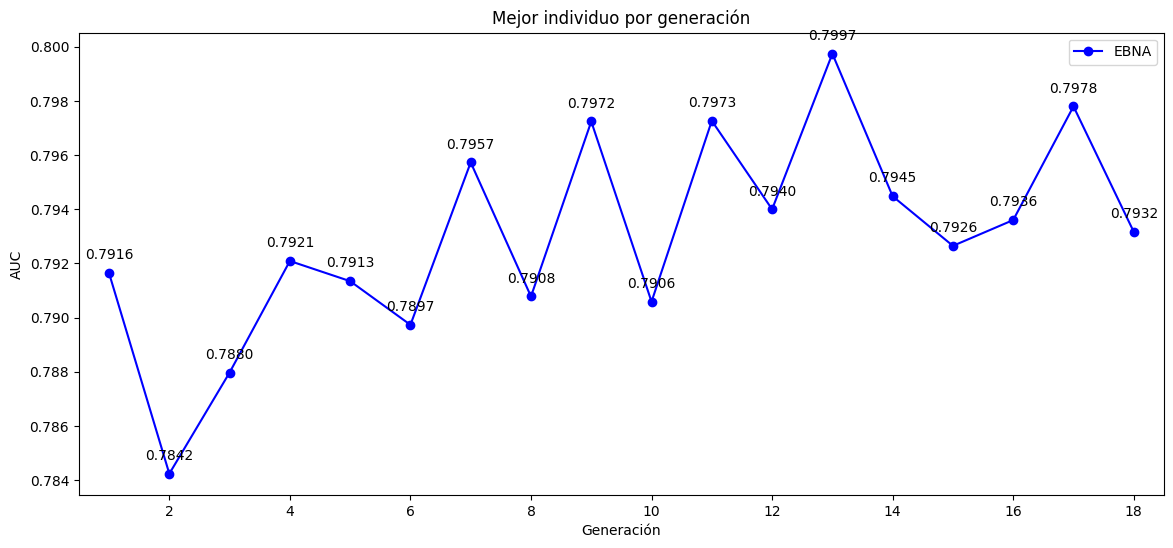

In [ ]:
import matplotlib.pyplot as plt
auc_values = [-x for x in ebna_result.history]

# Crear la figura y los ejes
plt.figure(figsize=(14, 6))

# Título y etiquetas
plt.title('Mejor individuo por generación')
plt.xlabel('Generación')
plt.ylabel('AUC')

# Corregir el rango del eje x para que comience en 1 y termine en el número de generaciones
generations = list(range(1, len(auc_values) + 1))

# Graficar la línea que muestra la mejora del AUC
plt.plot(generations, auc_values, color='b', label='EBNA', marker='o')

# Añadir una marca de dato en cada punto de la línea
for i, auc in enumerate(auc_values, start=1):
    plt.annotate(f'{auc:.4f}', (i, auc), textcoords="offset points", xytext=(0,10), ha='center')

# Mostrar la leyenda
plt.legend()

# Ajustar los límites del eje x para mejorar la presentación
plt.xlim(0.5, len(auc_values) + 0.5)

# Mostrar la gráfica
plt.show()

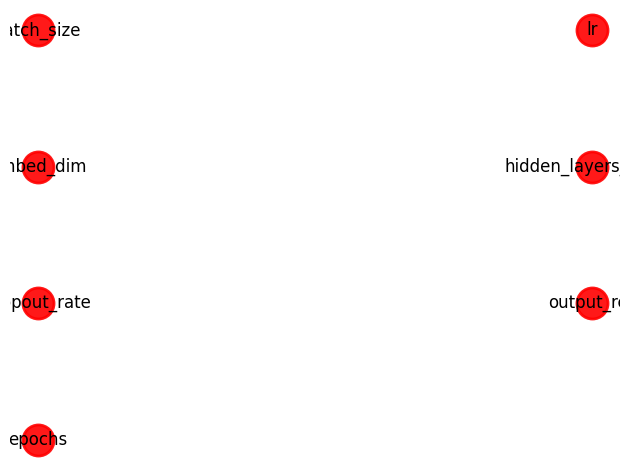

In [ ]:
from EDAspy.optimization import plot_bn
plot_bn(ebna.pm.print_structure(), var_names=variables)